In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../..')

In [3]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from stack_segmentation.stack import Stack

In [5]:
from stack_segmentation.io import make_dataloader, collate_fn_basic

from stack_segmentation.training import (
    handle_stacks_data, 
    make_optimization_task, 
    train_loop
)

from stack_segmentation.pipeline_config import (
    dataloaders_conf,
    train_conf,
    model_config, 
    aug_config,
    optimizer_config,
    loss_config,
    scheduler_config,
)

In [6]:
from exp_config import data_conf

## Parameters to tune

In [7]:
train_conf['device'] = 'cuda:1'
# train_conf['device'] = 'cpu'
train_conf['num_epochs'] = 500
train_conf

{'num_epochs': 500, 'device': 'cuda:1'}

In [8]:
data_conf['conf_name'] = 'exp_basic_adamw_lr1e-3_epoch_300_resnet50_encoder_soft_aug_k_1_weight10_patch64_v2'
data_conf['patches'] = {
    'train': (64, 64, 1),
    'val': (64, 64, 1),
    'test': (64, 64, 1)
}
data_conf

{'conf_name': 'exp_basic_adamw_lr1e-3_epoch_300_resnet50_encoder_soft_aug_k_1_weight10_patch64_v2',
 'stacks': [{'path': '../../data/carb96558',
   'slice_train': (slice(None, None, None),
    slice(None, None, None),
    slice(None, 230, None)),
   'slice_val': (slice(None, None, None),
    slice(None, None, None),
    slice(250, 470, None))},
  {'path': '../../data/SoilB-2',
   'slice_train': (slice(None, None, None),
    slice(None, None, None),
    slice(None, 230, None)),
   'slice_val': (slice(None, None, None),
    slice(None, None, None),
    slice(240, 460, None))},
  {'path': '../../data/Urna_22',
   'slice_train': (slice(None, None, None),
    slice(None, None, None),
    slice(None, 220, None)),
   'slice_val': (slice(None, None, None),
    slice(None, None, None),
    slice(245, 455, None))},
  {'path': '../../data/carb96558',
   'slice_test': (slice(None, None, None),
    slice(None, None, None),
    slice(490, None, None))},
  {'path': '../../data/carb71',
   'slice_test

In [9]:
model_config

{'source': 'qubvel',
 'model_type': 'Unet',
 'encoder_name': 'resnet50',
 'encoder_weights': 'imagenet'}

In [10]:
optimizer_config['opt_type'] = 'AdamW'
optimizer_config['lr'] = 5e-4
optimizer_config['weight_decay'] = 5e-5
optimizer_config['amsgrad'] = True
# optimizer_config['nesterov'] = True
optimizer_config

{'opt_type': 'AdamW',
 'lr': 0.0005,
 'weight_decay': 5e-05,
 'amsgrad': True,
 'nesterov': False,
 'momentum': 0.9,
 'centered': False}

In [11]:
aug_config['aug_type'] = 'soft'
aug_config['k'] = 1
aug_config['original_height'] = 64
aug_config['original_width'] = 64
aug_config

{'aug_type': 'soft', 'original_height': 64, 'original_width': 64, 'k': 1}

In [12]:
loss_config =[
    {
        'loss': 'BCE', 
        'weight': 1, 
        'params': {'weight': [1, 10]}},
    {
        'loss': 'Dice',
        'weight': 2, 
        'params': {
            'mode': 'multiclass',
            'classes': [1], # может быть, этот параметр не нужен
            'log_loss': True,
            'from_logits': True,
            'smooth': 1,
            'eps': 1e-7
        }
    }
]
loss_config

[{'loss': 'BCE', 'weight': 1, 'params': {'weight': [1, 10]}},
 {'loss': 'Dice',
  'weight': 2,
  'params': {'mode': 'multiclass',
   'classes': [1],
   'log_loss': True,
   'from_logits': True,
   'smooth': 1,
   'eps': 1e-07}}]

In [13]:
dataloaders_conf['train']['batch_size'] = 160
dataloaders_conf['val']['batch_size'] = 160
dataloaders_conf['test']['batch_size'] = 160
dataloaders_conf

{'train': {'batch_size': 160, 'num_workers': 16, 'shuffle': True},
 'val': {'batch_size': 160, 'num_workers': 16, 'shuffle': False},
 'test': {'batch_size': 160, 'num_workers': 16, 'shuffle': True}}

## Prepare train, validation and test data

In [14]:
data_train, data_val, data_test = handle_stacks_data(**data_conf)

720it [00:01, 448.19it/s]
100%|██████████| 720/720 [00:07<00:00, 95.35it/s] 
33120it [00:00, 251071.50it/s]
31680it [00:00, 159833.56it/s]
700it [00:00, 724.02it/s]
100%|██████████| 700/700 [00:06<00:00, 101.88it/s]
27830it [00:00, 140240.65it/s]
26620it [00:00, 241350.52it/s]
710it [00:01, 632.27it/s]
100%|██████████| 710/710 [00:07<00:00, 98.50it/s] 
31680it [00:00, 143125.79it/s]
30240it [00:00, 127924.65it/s]
720it [00:00, 818.34it/s]
100%|██████████| 720/720 [00:07<00:00, 102.11it/s]
33120it [00:00, 243228.10it/s]
720it [00:03, 234.64it/s]
100%|██████████| 720/720 [00:07<00:00, 97.96it/s] 
103680it [00:00, 177885.49it/s]
700it [00:03, 224.27it/s]
100%|██████████| 700/700 [00:06<00:00, 101.53it/s]
84700it [00:00, 229522.56it/s]
509it [00:01, 364.30it/s]
100%|██████████| 509/509 [00:02<00:00, 197.67it/s]
32576it [00:00, 92844.54it/s]
700it [00:02, 334.52it/s]
100%|██████████| 700/700 [00:07<00:00, 99.90it/s] 
84700it [00:00, 229103.08it/s]
700it [00:00, 813.45it/s]
100%|██████████| 

In [15]:
len(data_train), len(data_val), len(data_test)

(92630, 88540, 11)

In [16]:
dataloader_train = make_dataloader(
    samples=data_train, 
    collate_fn=collate_fn_basic,
    model_config=model_config,
    aug_config=aug_config,
    **dataloaders_conf['train']
)

dataloader_val = make_dataloader(
    samples=data_val, 
    collate_fn=collate_fn_basic,
    model_config=model_config,
    **dataloaders_conf['val']
)

dataloaders_test = {
    name: make_dataloader(
        samples=data, 
        collate_fn=collate_fn_basic,
        model_config=model_config,
        **dataloaders_conf['test']
    ) for name, data in data_test.items()}

## Create model and metrics

In [17]:
device = 'cuda:1'
# device = 'cpu'

In [18]:
model, criterion, optimizer, scheduler = make_optimization_task(
    device,
    model_config=model_config,
    loss_config=loss_config, 
    optimizer_config=optimizer_config,
    scheduler_config=scheduler_config)

## Run experiment

In [19]:
from stack_segmentation.metrics import accuracy, precision, recall, f1, pr_auc, iou

In [20]:
metrics = {
    'accuracy': accuracy, 
    'precision': precision, 
    'recall': recall, 
    'f1': f1,
    'pr_auc': pr_auc, 
    'iou': iou,
}

In [21]:
results = train_loop(
    model=model,
    dataloader_train=dataloader_train, 
    dataloader_val=dataloader_val,
    dataloaders_test=dataloaders_test,
    criterion=criterion, 
    optimizer=optimizer, 
    scheduler=scheduler,
    metrics=metrics,
    exp_name=data_conf['conf_name'],
    **train_conf)

  0%|          | 0/579 [00:00<?, ?it/s]

Epoch 0...


  0%|          | 0/554 [00:00<?, ?it/s]

Mean train loss: 0.18717


100%|██████████| 554/554 [00:32<00:00, 16.88it/s]


Mean val loss: 0.081107


  0%|          | 0/579 [00:00<?, ?it/s]

Epoch 1...


  0%|          | 0/554 [00:00<?, ?it/s]

Mean train loss: 0.050091


100%|██████████| 554/554 [00:33<00:00, 16.70it/s]


Mean val loss: 0.041154


  0%|          | 0/579 [00:00<?, ?it/s]

Epoch 2...


  0%|          | 0/554 [00:00<?, ?it/s]

Mean train loss: 0.038323


  0%|          | 0/579 [00:00<?, ?it/s]

Mean val loss: 0.041568
EarlyStopping counter: 1 out of 15
Epoch 3...


  0%|          | 0/554 [00:00<?, ?it/s]

Mean train loss: 0.034484


  0%|          | 0/579 [00:00<?, ?it/s]

Mean val loss: 0.041303
EarlyStopping counter: 2 out of 15
Epoch 4...


  0%|          | 0/554 [00:00<?, ?it/s]

Mean train loss: 0.032668


100%|██████████| 554/554 [00:34<00:00, 16.23it/s]


Mean val loss: 0.035317


  0%|          | 0/579 [00:00<?, ?it/s]

Epoch 5...


  0%|          | 0/554 [00:00<?, ?it/s]

Mean train loss: 0.031075


  0%|          | 0/579 [00:00<?, ?it/s]

Mean val loss: 0.035541
EarlyStopping counter: 1 out of 15
Epoch 6...


  0%|          | 0/554 [00:00<?, ?it/s]

Mean train loss: 0.030498


  0%|          | 0/579 [00:00<?, ?it/s]

Mean val loss: 0.036949
EarlyStopping counter: 2 out of 15
Epoch 7...


  0%|          | 0/554 [00:00<?, ?it/s]

Mean train loss: 0.029325


100%|██████████| 554/554 [00:33<00:00, 16.38it/s]


Mean val loss: 0.029235


  0%|          | 0/579 [00:00<?, ?it/s]

Epoch 8...


  0%|          | 0/554 [00:00<?, ?it/s]

Mean train loss: 0.028926


  0%|          | 0/579 [00:00<?, ?it/s]

Mean val loss: 0.034709
EarlyStopping counter: 1 out of 15
Epoch 9...


  0%|          | 0/554 [00:00<?, ?it/s]

Mean train loss: 0.028374


  0%|          | 0/579 [00:00<?, ?it/s]

Mean val loss: 0.029759
EarlyStopping counter: 2 out of 15
Epoch 10...


  0%|          | 0/554 [00:00<?, ?it/s]

Mean train loss: 0.027921


100%|██████████| 554/554 [00:34<00:00, 16.27it/s]


Mean val loss: 0.028076


  0%|          | 0/579 [00:00<?, ?it/s]

Epoch 11...


  0%|          | 0/554 [00:00<?, ?it/s]

Mean train loss: 0.027665


  0%|          | 0/579 [00:00<?, ?it/s]

Mean val loss: 0.028821
EarlyStopping counter: 1 out of 15
Epoch 12...


  0%|          | 0/554 [00:00<?, ?it/s]

Mean train loss: 0.027404


100%|██████████| 554/554 [00:34<00:00, 16.09it/s]


Mean val loss: 0.027706


  0%|          | 0/579 [00:00<?, ?it/s]

Epoch 13...


  0%|          | 0/554 [00:00<?, ?it/s]

Mean train loss: 0.027151


  0%|          | 0/579 [00:00<?, ?it/s]

Mean val loss: 0.029421
EarlyStopping counter: 1 out of 15
Epoch 14...


  0%|          | 0/554 [00:00<?, ?it/s]

Mean train loss: 0.026833


  0%|          | 0/579 [00:00<?, ?it/s]

Mean val loss: 0.028775
EarlyStopping counter: 2 out of 15
Epoch 15...


  0%|          | 0/554 [00:00<?, ?it/s]

Mean train loss: 0.026755


  0%|          | 0/579 [00:00<?, ?it/s]

Mean val loss: 0.028611
EarlyStopping counter: 3 out of 15
Epoch 16...


  0%|          | 0/554 [00:00<?, ?it/s]

Mean train loss: 0.026468


  0%|          | 0/579 [00:00<?, ?it/s]

Mean val loss: 0.037143
EarlyStopping counter: 4 out of 15
Epoch 17...


  0%|          | 0/554 [00:00<?, ?it/s]

Mean train loss: 0.026473


  0%|          | 0/579 [00:00<?, ?it/s]

Mean val loss: 0.03258
EarlyStopping counter: 5 out of 15
Epoch 18...


  0%|          | 0/554 [00:00<?, ?it/s]

Mean train loss: 0.026551


100%|██████████| 554/554 [00:34<00:00, 16.11it/s]


Mean val loss: 0.027454


  0%|          | 0/579 [00:00<?, ?it/s]

Epoch 19...


  0%|          | 0/554 [00:00<?, ?it/s]

Mean train loss: 0.026278


  0%|          | 0/579 [00:00<?, ?it/s]

Mean val loss: 0.029844
EarlyStopping counter: 1 out of 15
Epoch 20...


  0%|          | 0/554 [00:00<?, ?it/s]

Mean train loss: 0.025961


100%|██████████| 554/554 [00:33<00:00, 16.49it/s]


Mean val loss: 0.026615


  0%|          | 0/579 [00:00<?, ?it/s]

Epoch 21...


  0%|          | 0/554 [00:00<?, ?it/s]

Mean train loss: 0.025897


100%|██████████| 554/554 [00:33<00:00, 16.44it/s]


Mean val loss: 0.026369


  0%|          | 0/579 [00:00<?, ?it/s]

Epoch 22...


  0%|          | 0/554 [00:00<?, ?it/s]

Mean train loss: 0.025809


  0%|          | 0/579 [00:00<?, ?it/s]

Mean val loss: 0.026746
EarlyStopping counter: 1 out of 15
Epoch 23...


  0%|          | 0/554 [00:00<?, ?it/s]

Mean train loss: 0.025804


  0%|          | 0/579 [00:00<?, ?it/s]

Mean val loss: 0.026794
EarlyStopping counter: 2 out of 15
Epoch 24...


  0%|          | 0/554 [00:00<?, ?it/s]

Mean train loss: 0.025629


100%|██████████| 554/554 [00:33<00:00, 16.46it/s]


Mean val loss: 0.026116


  0%|          | 0/579 [00:00<?, ?it/s]

Epoch 25...


  0%|          | 0/554 [00:00<?, ?it/s]

Mean train loss: 0.025443


  0%|          | 0/579 [00:00<?, ?it/s]

Mean val loss: 0.027095
EarlyStopping counter: 1 out of 15
Epoch 26...


  0%|          | 0/554 [00:00<?, ?it/s]

Mean train loss: 0.02537


100%|██████████| 554/554 [00:34<00:00, 16.17it/s]


Mean val loss: 0.02611


  0%|          | 0/579 [00:00<?, ?it/s]

Epoch 27...


  0%|          | 0/554 [00:00<?, ?it/s]

Mean train loss: 0.025322


  0%|          | 0/579 [00:00<?, ?it/s]

Mean val loss: 0.026144
EarlyStopping counter: 1 out of 15
Epoch 28...


  0%|          | 0/554 [00:00<?, ?it/s]

Mean train loss: 0.025284


100%|██████████| 554/554 [00:33<00:00, 16.31it/s]


Mean val loss: 0.026037


  0%|          | 0/579 [00:00<?, ?it/s]

Epoch 29...


  0%|          | 0/554 [00:00<?, ?it/s]

Mean train loss: 0.025149


100%|██████████| 554/554 [00:34<00:00, 16.14it/s]


Mean val loss: 0.025621


  0%|          | 0/579 [00:00<?, ?it/s]

Epoch 30...


  0%|          | 0/554 [00:00<?, ?it/s]

Mean train loss: 0.025122


100%|██████████| 554/554 [00:34<00:00, 16.28it/s]


Mean val loss: 0.02562


  0%|          | 0/579 [00:00<?, ?it/s]

Epoch 31...


  0%|          | 0/554 [00:00<?, ?it/s]

Mean train loss: 0.025056


100%|██████████| 554/554 [00:34<00:00, 16.00it/s]


Mean val loss: 0.025567


  0%|          | 0/579 [00:00<?, ?it/s]

Epoch 32...


  0%|          | 0/554 [00:00<?, ?it/s]

Mean train loss: 0.025022


  0%|          | 0/579 [00:00<?, ?it/s]

Mean val loss: 0.02623
EarlyStopping counter: 1 out of 15
Epoch 33...


  0%|          | 0/554 [00:00<?, ?it/s]

Mean train loss: 0.024964


100%|██████████| 554/554 [00:34<00:00, 16.22it/s]


Mean val loss: 0.025464


  0%|          | 0/579 [00:00<?, ?it/s]

Epoch 34...


  0%|          | 0/554 [00:00<?, ?it/s]

Mean train loss: 0.024766


100%|██████████| 554/554 [00:34<00:00, 16.00it/s]


Mean val loss: 0.025341


  0%|          | 0/579 [00:00<?, ?it/s]

Epoch 35...


  0%|          | 0/554 [00:00<?, ?it/s]

Mean train loss: 0.024804


100%|██████████| 554/554 [00:34<00:00, 15.85it/s]


Mean val loss: 0.025311


  0%|          | 0/579 [00:00<?, ?it/s]

Epoch 36...


  0%|          | 0/554 [00:00<?, ?it/s]

Mean train loss: 0.024645


  0%|          | 0/579 [00:00<?, ?it/s]

Mean val loss: 0.027003
EarlyStopping counter: 1 out of 15
Epoch 37...


  0%|          | 0/554 [00:00<?, ?it/s]

Mean train loss: 0.024622


  0%|          | 0/579 [00:00<?, ?it/s]

Mean val loss: 0.025528
EarlyStopping counter: 2 out of 15
Epoch 38...


  0%|          | 0/554 [00:00<?, ?it/s]

Mean train loss: 0.024554


  0%|          | 0/579 [00:00<?, ?it/s]

Mean val loss: 0.025353
EarlyStopping counter: 3 out of 15
Epoch 39...


  0%|          | 0/554 [00:00<?, ?it/s]

Mean train loss: 0.024418


  0%|          | 0/579 [00:00<?, ?it/s]

Mean val loss: 0.02545
EarlyStopping counter: 4 out of 15
Epoch 40...


  0%|          | 0/554 [00:00<?, ?it/s]

Mean train loss: 0.024412


100%|██████████| 554/554 [00:34<00:00, 16.03it/s]


Mean val loss: 0.025234


  0%|          | 0/579 [00:00<?, ?it/s]

Epoch 41...


  0%|          | 0/554 [00:00<?, ?it/s]

Mean train loss: 0.024313


  0%|          | 0/579 [00:00<?, ?it/s]

Mean val loss: 0.025681
EarlyStopping counter: 1 out of 15
Epoch 42...


  0%|          | 0/554 [00:00<?, ?it/s]

Mean train loss: 0.02432


100%|██████████| 554/554 [00:34<00:00, 16.01it/s]


Mean val loss: 0.024861


  0%|          | 0/579 [00:00<?, ?it/s]

Epoch 43...


  0%|          | 0/554 [00:00<?, ?it/s]

Mean train loss: 0.024174


  0%|          | 0/579 [00:00<?, ?it/s]

Mean val loss: 0.025225
EarlyStopping counter: 1 out of 15
Epoch 44...


  0%|          | 0/554 [00:00<?, ?it/s]

Mean train loss: 0.02421


100%|██████████| 554/554 [00:33<00:00, 16.36it/s]


Mean val loss: 0.024855


  0%|          | 0/579 [00:00<?, ?it/s]

Epoch 45...


  0%|          | 0/554 [00:00<?, ?it/s]

Mean train loss: 0.024041


  0%|          | 0/579 [00:00<?, ?it/s]

Mean val loss: 0.024919
EarlyStopping counter: 1 out of 15
Epoch 46...


  0%|          | 0/554 [00:00<?, ?it/s]

Mean train loss: 0.024046


  0%|          | 0/579 [00:00<?, ?it/s]

Mean val loss: 0.025378
EarlyStopping counter: 2 out of 15
Epoch 47...


  0%|          | 0/554 [00:00<?, ?it/s]

Mean train loss: 0.023992


  0%|          | 0/579 [00:00<?, ?it/s]

Mean val loss: 0.028772
EarlyStopping counter: 3 out of 15
Epoch 48...


  0%|          | 0/554 [00:00<?, ?it/s]

Mean train loss: 0.023926


  0%|          | 0/579 [00:00<?, ?it/s]

Mean val loss: 0.026013
EarlyStopping counter: 4 out of 15
Epoch 49...


  0%|          | 0/554 [00:00<?, ?it/s]

Mean train loss: 0.023829


100%|██████████| 554/554 [00:33<00:00, 16.48it/s]


Mean val loss: 0.024725


  0%|          | 0/579 [00:00<?, ?it/s]

Epoch 50...


  0%|          | 0/554 [00:00<?, ?it/s]

Mean train loss: 0.023771


  0%|          | 0/579 [00:00<?, ?it/s]

Mean val loss: 0.025066
EarlyStopping counter: 1 out of 15
Epoch 51...


  0%|          | 0/554 [00:00<?, ?it/s]

Mean train loss: 0.023717


  0%|          | 0/579 [00:00<?, ?it/s]

Mean val loss: 0.026044
EarlyStopping counter: 2 out of 15
Epoch 52...


  0%|          | 0/554 [00:00<?, ?it/s]

Mean train loss: 0.023661


  0%|          | 0/579 [00:00<?, ?it/s]

Mean val loss: 0.027254
EarlyStopping counter: 3 out of 15
Epoch 53...


  0%|          | 0/554 [00:00<?, ?it/s]

Mean train loss: 0.023592


  0%|          | 0/579 [00:00<?, ?it/s]

Mean val loss: 0.025002
EarlyStopping counter: 4 out of 15
Epoch 54...


  0%|          | 0/554 [00:00<?, ?it/s]

Mean train loss: 0.023473


100%|██████████| 554/554 [00:33<00:00, 16.54it/s]


Mean val loss: 0.02467


  0%|          | 0/579 [00:00<?, ?it/s]

Epoch 55...


  0%|          | 0/554 [00:00<?, ?it/s]

Mean train loss: 0.02352


100%|██████████| 554/554 [00:33<00:00, 16.43it/s]


Mean val loss: 0.024542


  0%|          | 0/579 [00:00<?, ?it/s]

Epoch 56...


  0%|          | 0/554 [00:00<?, ?it/s]

Mean train loss: 0.023446


  0%|          | 0/579 [00:00<?, ?it/s]

Mean val loss: 0.031004
EarlyStopping counter: 1 out of 15
Epoch 57...


  0%|          | 0/554 [00:00<?, ?it/s]

Mean train loss: 0.023434


  0%|          | 0/579 [00:00<?, ?it/s]

Mean val loss: 0.025682
EarlyStopping counter: 2 out of 15
Epoch 58...


  0%|          | 0/554 [00:00<?, ?it/s]

Mean train loss: 0.023365


  0%|          | 0/579 [00:00<?, ?it/s]

Mean val loss: 0.032209
EarlyStopping counter: 3 out of 15
Epoch 59...


  0%|          | 0/554 [00:00<?, ?it/s]

Mean train loss: 0.023285


100%|██████████| 554/554 [00:33<00:00, 16.31it/s]


Mean val loss: 0.024458


  0%|          | 0/579 [00:00<?, ?it/s]

Epoch 60...


  0%|          | 0/554 [00:00<?, ?it/s]

Mean train loss: 0.023245


  0%|          | 0/579 [00:00<?, ?it/s]

Mean val loss: 0.024816
EarlyStopping counter: 1 out of 15
Epoch 61...


  0%|          | 0/554 [00:00<?, ?it/s]

Mean train loss: 0.023293


100%|██████████| 554/554 [00:34<00:00, 16.03it/s]


Mean val loss: 0.024145


  0%|          | 0/579 [00:00<?, ?it/s]

Epoch 62...


  0%|          | 0/554 [00:00<?, ?it/s]

Mean train loss: 0.023224


  0%|          | 0/579 [00:00<?, ?it/s]

Mean val loss: 0.025066
EarlyStopping counter: 1 out of 15
Epoch 63...


  0%|          | 0/554 [00:00<?, ?it/s]

Mean train loss: 0.023123


  0%|          | 0/579 [00:00<?, ?it/s]

Mean val loss: 0.024965
EarlyStopping counter: 2 out of 15
Epoch 64...


  0%|          | 0/554 [00:00<?, ?it/s]

Mean train loss: 0.023133


  0%|          | 0/579 [00:00<?, ?it/s]

Mean val loss: 0.024204
EarlyStopping counter: 3 out of 15
Epoch 65...


  0%|          | 0/554 [00:00<?, ?it/s]

Mean train loss: 0.023225


  0%|          | 0/579 [00:00<?, ?it/s]

Mean val loss: 0.0321
EarlyStopping counter: 4 out of 15
Epoch 66...


  0%|          | 0/554 [00:00<?, ?it/s]

Mean train loss: 0.023061


  0%|          | 0/579 [00:00<?, ?it/s]

Mean val loss: 0.02513
EarlyStopping counter: 5 out of 15
Epoch 67...


  0%|          | 0/554 [00:00<?, ?it/s]

Mean train loss: 0.02296


  0%|          | 0/579 [00:00<?, ?it/s]

Mean val loss: 0.02466
EarlyStopping counter: 6 out of 15
Epoch 68...


  0%|          | 0/554 [00:00<?, ?it/s]

Mean train loss: 0.022938


  0%|          | 0/579 [00:00<?, ?it/s]

Mean val loss: 0.028712
EarlyStopping counter: 7 out of 15
Epoch 69...


  0%|          | 0/554 [00:00<?, ?it/s]

Mean train loss: 0.022843


  0%|          | 0/579 [00:00<?, ?it/s]

Mean val loss: 0.026194
EarlyStopping counter: 8 out of 15
Epoch 70...


  0%|          | 0/554 [00:00<?, ?it/s]

Mean train loss: 0.022982


  0%|          | 0/579 [00:00<?, ?it/s]

Mean val loss: 0.024931
EarlyStopping counter: 9 out of 15
Epoch 71...


  0%|          | 0/554 [00:00<?, ?it/s]

Mean train loss: 0.022815


  0%|          | 0/579 [00:00<?, ?it/s]

Mean val loss: 0.025219
EarlyStopping counter: 10 out of 15
Epoch 72...


  0%|          | 0/554 [00:00<?, ?it/s]

Mean train loss: 0.022761


100%|██████████| 554/554 [00:34<00:00, 15.96it/s]


Mean val loss: 0.024016


  0%|          | 0/579 [00:00<?, ?it/s]

Epoch 73...


  0%|          | 0/554 [00:00<?, ?it/s]

Mean train loss: 0.022762


  0%|          | 0/579 [00:00<?, ?it/s]

Mean val loss: 0.024634
EarlyStopping counter: 1 out of 15
Epoch 74...


  0%|          | 0/554 [00:00<?, ?it/s]

Mean train loss: 0.022698


  0%|          | 0/579 [00:00<?, ?it/s]

Mean val loss: 0.025183
EarlyStopping counter: 2 out of 15
Epoch 75...


  0%|          | 0/554 [00:00<?, ?it/s]

Mean train loss: 0.022656


  0%|          | 0/579 [00:00<?, ?it/s]

Mean val loss: 0.024277
EarlyStopping counter: 3 out of 15
Epoch 76...


  0%|          | 0/554 [00:00<?, ?it/s]

Mean train loss: 0.022577


  0%|          | 0/579 [00:00<?, ?it/s]

Mean val loss: 0.028195
EarlyStopping counter: 4 out of 15
Epoch 77...


  0%|          | 0/554 [00:00<?, ?it/s]

Mean train loss: 0.022558


  0%|          | 0/579 [00:00<?, ?it/s]

Mean val loss: 0.024176
EarlyStopping counter: 5 out of 15
Epoch 78...


  0%|          | 0/554 [00:00<?, ?it/s]

Mean train loss: 0.022539


  0%|          | 0/579 [00:00<?, ?it/s]

Mean val loss: 0.033475
EarlyStopping counter: 6 out of 15
Epoch 79...


  0%|          | 0/554 [00:00<?, ?it/s]

Mean train loss: 0.022484


  0%|          | 0/579 [00:00<?, ?it/s]

Mean val loss: 0.056944
EarlyStopping counter: 7 out of 15
Epoch 80...


  0%|          | 0/554 [00:00<?, ?it/s]

Mean train loss: 0.02253


  0%|          | 0/579 [00:00<?, ?it/s]

Mean val loss: 0.031534
EarlyStopping counter: 8 out of 15
Epoch 81...


  0%|          | 0/554 [00:00<?, ?it/s]

Mean train loss: 0.022364


  0%|          | 0/579 [00:00<?, ?it/s]

Mean val loss: 0.026144
EarlyStopping counter: 9 out of 15
Epoch 82...


  0%|          | 0/554 [00:00<?, ?it/s]

Mean train loss: 0.022347


  0%|          | 0/579 [00:00<?, ?it/s]

Mean val loss: 0.024807
EarlyStopping counter: 10 out of 15
Epoch 83...


  0%|          | 0/554 [00:00<?, ?it/s]

Mean train loss: 0.022328


  0%|          | 0/579 [00:00<?, ?it/s]

Mean val loss: 0.032265
EarlyStopping counter: 11 out of 15
Epoch 84...


  0%|          | 0/554 [00:00<?, ?it/s]

Mean train loss: 0.022284


  0%|          | 0/579 [00:00<?, ?it/s]

Mean val loss: 0.025607
EarlyStopping counter: 12 out of 15
Epoch 85...


  0%|          | 0/554 [00:00<?, ?it/s]

Mean train loss: 0.022359


  0%|          | 0/579 [00:00<?, ?it/s]

Mean val loss: 0.02433
EarlyStopping counter: 13 out of 15
Epoch 86...


  0%|          | 0/554 [00:00<?, ?it/s]

Mean train loss: 0.022579


  0%|          | 0/579 [00:00<?, ?it/s]

Mean val loss: 0.03973
EarlyStopping counter: 14 out of 15
Epoch 87...


  0%|          | 0/554 [00:00<?, ?it/s]

Mean train loss: 0.022336


  0%|          | 0/207 [00:00<?, ?it/s]

Mean val loss: 0.026267
EarlyStopping counter: 15 out of 15


 79%|███████▊  | 503/639 [06:56<01:52,  1.21it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## Dump experiment results

In [22]:
import pickle
import json

In [23]:
p = './{}_exp_results.pkl'.format(data_conf['conf_name'])
with open(p, 'wb') as f:
    pickle.dump(results, f)

In [28]:
# p = './{}_exp_results.pkl'.format(data_conf['conf_name'])
# with open(p, 'rb') as f:
#     results = pickle.load(f)

In [11]:
import torch
model.load_state_dict(torch.load('./{}.pt'.format(data_conf['conf_name'])))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

## Train and validation losses

In [24]:
from itertools import chain

In [25]:
train_losses = list(chain(*[item for item in results['train_losses']]))
val_losses = list(chain(*[item for item in results['val_losses']]))

In [26]:
def moving_average(a, n=5) :
    ret = np.cumsum([a[0]] * (n - 1) + a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

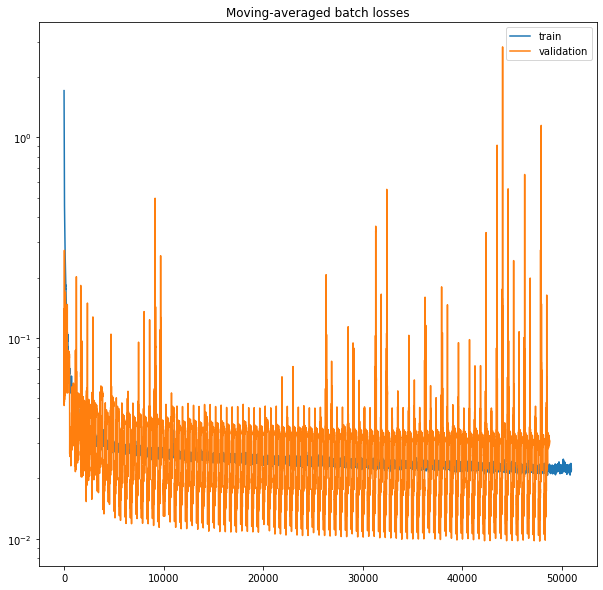

In [27]:
plt.figure(figsize=(10, 10))
plt.title('Moving-averaged batch losses')
plt.plot(np.arange(len(train_losses)), moving_average(train_losses), label='train')
plt.plot(np.arange(len(val_losses)), moving_average(val_losses), label='validation')

plt.legend(loc='best')
plt.yscale('log')

# plt.ylim([1e-2, 1])
plt.show()

In [28]:
mean_train_loss = [np.mean(item) for item in results['train_losses']]
mean_val_loss = [np.mean(item) for item in results['val_losses']]

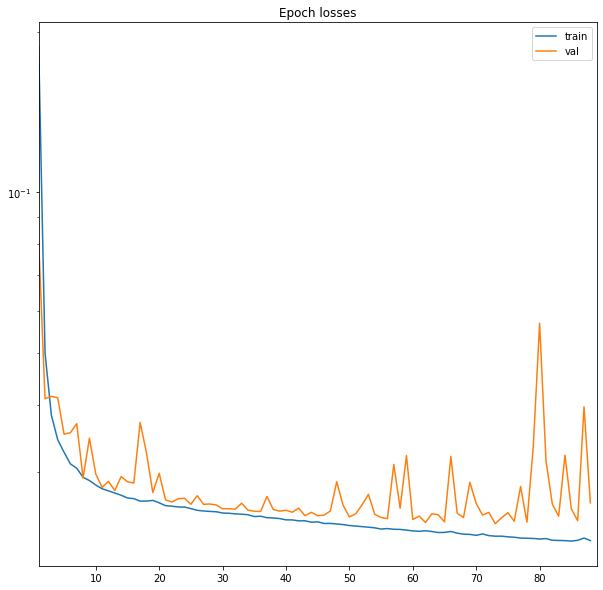

In [29]:
plt.figure(figsize=(10, 10))
plt.title('Epoch losses')
plt.plot(np.arange(len(mean_train_loss)) + 1, mean_train_loss, label='train')
plt.plot(np.arange(len(mean_val_loss)) + 1, mean_val_loss, label='val')

plt.yscale('log')
plt.legend(loc='best')

plt.xlim([1, len(mean_train_loss) + 1])
plt.show()

## Results

In [30]:
import pandas as pd

In [31]:
from visualization_utils import make_df

In [32]:
df = make_df(results, model_name='basic')
df

,accuracy,precision,recall,f1,pr_auc,iou,stack,model
0,0.995877,0.953394,0.996626,0.974531,0.998781,0.950327,carb96558,basic
1,0.984651,0.882995,0.996977,0.936531,0.989861,0.880638,carb71,basic
2,0.981991,0.901775,0.944343,0.922568,0.977383,0.856266,carbRNF,basic
3,0.996101,0.986617,0.949973,0.967948,0.996935,0.937887,SPE_carb10_58_box3,basic
4,0.990328,0.952446,0.957477,0.954955,0.993881,0.913792,SoilAh-1,basic
5,0.993176,0.917408,0.992678,0.953560,0.996368,0.911242,SoilB-2,basic
6,0.990939,0.993461,0.937907,0.964885,0.988853,0.932152,TeTree_subset1,basic
7,0.994188,0.993639,0.957000,0.974975,0.992325,0.951172,TiTree_subset2,basic
8,0.990918,0.937079,0.995898,0.965593,0.997899,0.933476,Urna_22,basic
9,0.988785,0.944783,0.989111,0.966439,0.997707,0.935057,Urna_30,basic


In [33]:
print('Mean   IOU: {:.5}'.format(df['iou'].mean()))
print('Std    IOU: {:.5}'.format(df['iou'].std()))
print('Min    IOU: {:.5}'.format(df['iou'].min()))
print('Median IOU: {:.5}'.format(df['iou'].median()))

Mean   IOU: 0.91889
Std    IOU: 0.029465
Min    IOU: 0.85627
Median IOU: 0.93215


## Check loss to loss ratio

In [34]:
criterion.losses

(WeightedLoss(
   (loss): CrossEntropyLoss()
 ), WeightedLoss(
   (loss): DiceLoss()
 ))

In [35]:
from stack_segmentation.training import make_joint_loss

In [36]:
import torch

In [37]:
# loss_config[0] = {'loss': 'BCE',
#   'weight': 0.5,
#   'params': {}}
# loss_config
# crit = make_joint_loss(device=device, loss_config=loss_config)

In [38]:
crit = criterion
a = []
b = []
for i, (x, y) in enumerate(dataloader_val):
    if i > 100:
        break
    pred = model(torch.from_numpy(x).to(device))
    y = torch.from_numpy(y).to(device)
    a.append(crit.losses[0](pred, y).cpu().data.numpy())
    b.append(crit.losses[1](pred, y).cpu().data.numpy())

In [39]:
print('Mean 0 loss: {:.4f}\nMean 1 loss: {:.4f}\nMean of ratios: {:.4f}\nRatio of means: {:.4f}'
      .format(np.mean(a), np.mean(b), np.mean(np.array(a) / np.array(b)), np.mean(a) / np.mean(b)))

Mean 0 loss: 0.0102
Mean 1 loss: 0.0044
Mean of ratios: 2.4543
Ratio of means: 2.3201
